In [1]:
%matplotlib qt
import tqdm
import bagpy
import pygad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
b = bagpy.bagreader('./bags_new/bag3.bag')
# get the list of topics
print(b.topic_table)
# get all the messages of all topics
csvfiles = []
for t in b.topics:
    data = b.message_by_topic(t)
    csvfiles.append(data)

poses = pd.read_csv(csvfiles[0])
wheel_states = pd.read_csv(csvfiles[1])
print(wheel_states)
poses

[INFO]  Data folder ./bags_new/bag3 already exists. Not creating.
          Topics                      Types  Message Count   Frequency
0    /robot/pose  geometry_msgs/PoseStamped          17799  174.421092
1  /wheel_states     sensor_msgs/JointState           5149   48.976564
              Time  header.seq  header.stamp.secs  header.stamp.nsecs  \
0     1.649349e+09           1         1649348785            31191825   
1     1.649349e+09           2         1649348785            51174163   
2     1.649349e+09           3         1649348785            71672916   
3     1.649349e+09           4         1649348785            92028141   
4     1.649349e+09           5         1649348785           112309455   
...            ...         ...                ...                 ...   
5144  1.649349e+09        5145         1649348890           272181749   
5145  1.649349e+09        5146         1649348890           292039871   
5146  1.649349e+09        5147         1649348890           3133

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,pose.position.x,pose.position.y,pose.position.z,pose.orientation.x,pose.orientation.y,pose.orientation.z,pose.orientation.w
0,1.649349e+09,185006,1649348784,993775398,world,0.005460,0.039970,0.370361,-0.010593,-0.024768,-0.006752,0.999614
1,1.649349e+09,185007,1649348785,2962371,world,0.005272,0.039899,0.370252,-0.008938,-0.016773,0.000029,0.999819
2,1.649349e+09,185008,1649348785,4231558,world,0.005701,0.040275,0.370213,-0.007415,-0.024286,-0.007835,0.999647
3,1.649349e+09,185009,1649348785,11670943,world,0.005472,0.039882,0.370159,-0.010821,-0.022694,-0.001732,0.999682
4,1.649349e+09,185010,1649348785,17029274,world,0.005541,0.039964,0.370194,-0.009629,-0.023609,-0.003327,0.999669
...,...,...,...,...,...,...,...,...,...,...,...,...
17794,1.649349e+09,202800,1649348890,313442892,world,-0.005280,0.023007,0.370406,0.018180,-0.043580,-0.000276,0.998884
17795,1.649349e+09,202801,1649348890,318506406,world,-0.005190,0.021783,0.371000,0.005611,-0.039376,-0.001610,0.999207
17796,1.649349e+09,202802,1649348890,323936490,world,-0.005728,0.023108,0.371193,0.016323,-0.050367,0.000637,0.998597
17797,1.649349e+09,202803,1649348890,330557147,world,-0.005387,0.022606,0.370996,-0.011536,-0.002539,-0.000360,0.999930


In [3]:
# The ticks variable in the odometry represent the number of tick from the absolute beginning
# of the wheel recording! Not the realtime position of the wheel. It's basically a counter
def compute_trajectory(wheel_states, poses, r=0.07, l=0.2, w=0.169, N=42, use_ticks=True, euler=True):
    T = 5 #Gear ratio
    #N = Number of ticks on wheel encoder

    # must be equal to the initial pose!! They must look in same direction!
    x = poses['pose.position.x'][0]
    y = poses['pose.position.y'][0]
    theta = poses['pose.orientation.z'][0]
    pose_arr = np.array([[x,y,theta]])

    for i in range(1, len(wheel_states)):
        dt = wheel_states['Time'][i] - wheel_states['Time'][i-1]

        # Wheel ANGULAR VELOCITY, radians/second
        if use_ticks:
            wheel0_rps = 2*np.pi*(wheel_states['position_0'][i] - wheel_states['position_0'][i-1]) / (T * N * dt)
            wheel1_rps = 2*np.pi*(wheel_states['position_1'][i] - wheel_states['position_1'][i-1]) / (T * N * dt)
            wheel2_rps = 2*np.pi*(wheel_states['position_2'][i] - wheel_states['position_2'][i-1]) / (T * N * dt)
            wheel3_rps = 2*np.pi*(wheel_states['position_3'][i] - wheel_states['position_3'][i-1]) / (T * N * dt)
        else:
            wheel0_rps = wheel_states['velocity_0'][i] / 60 / T
            wheel1_rps = wheel_states['velocity_1'][i] / 60 / T
            wheel2_rps = wheel_states['velocity_2'][i] / 60 / T
            wheel3_rps = wheel_states['velocity_3'][i] / 60 / T

        # vx, vy, w
        lin_vel_x = (r / 4) * (wheel0_rps + wheel1_rps + wheel2_rps + wheel3_rps)
        lin_vel_y = (r / 4) * (-wheel0_rps + wheel1_rps + wheel2_rps - wheel3_rps)
        ang_vel = (r / 4) * (1 / (l + w)) * (-wheel0_rps + wheel1_rps - wheel2_rps + wheel3_rps)

        # Odom
        delta_x = lin_vel_x * dt
        delta_y = lin_vel_y * dt
        delta_theta = ang_vel * dt

        if euler: # Euler
            x += delta_x * np.cos(theta) - delta_y * np.sin(theta)
            y += delta_x * np.sin(theta) + delta_y * np.cos(theta)
        else: # Runge-Kutta
            x += delta_x * np.cos(theta + ang_vel * dt / 2) - delta_y * np.sin(theta + ang_vel * dt / 2)
            y += delta_x * np.sin(theta + ang_vel * dt / 2) + delta_y * np.cos(theta + ang_vel * dt / 2)
        theta += delta_theta
        
        pose_arr = np.concatenate((pose_arr, np.array([[x,y,theta]])), axis=0)
    return pose_arr

In [4]:
# Default
#r=0.07
#l=0.2
#w=0.169
#N=42
# Optimized
r=0.07007972256976944
l=0.19943134513875557
w=0.1680582071314848
N=38
r=0.0700368088348283
l=0.1812399329620913
w=0.18574904307836762
N=38

fig = plt.figure(figsize=(22,11))
plt.title('OptiTrack:Blue - ticks:red - gearVelocity:green')

ground_truth_traj = poses[['pose.position.x', 'pose.position.y']].to_numpy()
plt.scatter(ground_truth_traj[:,0], ground_truth_traj[:,1], color='blue')

pose_arr = compute_trajectory(wheel_states, poses,
                              r=r, l=l, w=w, N=N,
                              use_ticks=True)
plt.scatter(pose_arr[:,0],pose_arr[:,1], color='red')

pose_arr = compute_trajectory(wheel_states, poses,
                              r=r, l=l, w=w, N=N,
                              use_ticks=False)
plt.scatter(pose_arr[:,0],pose_arr[:,1], color='green')

In [5]:
'''The algorithm computes the average distance between n_points of the points of the ground truth and their
    closest point in the trajectory traj. Timestamps cannot be used because optitrack is not reliable
:param ground_truth_traj: numpy ndarray (num_points, 2), (x,y) positions, ground truth trajectory
:param traj: numpy ndarray (num_points, 3), (x,y,th) positions, traj to compute the avg dist with ground truth
:param n_points: number of points to sample from ground truth, the algorithm computes the average distance
                    between these points and the closest point of the trajectory traj
'''
def compute_avg_dist(ground_truth_traj, traj, n_points=500):
    step = len(ground_truth_traj) // n_points # step between one point and the next to extract n_points
    
    # Sample n_points from ground truth
    error = 0
    for i in range(0, len(ground_truth_traj), step):
        pt_ground_truth = ground_truth_traj[i,:2]
        # Compute distance of closest point in traj
        l2_dist = np.sqrt(np.sum(np.square(traj[:,:2] - pt_ground_truth), axis=1))
        min_dist = np.min(l2_dist) # distance of the closest point
        error += min_dist
    
    # Average distance - error
    error = error / n_points
    return error

'''Allows to regularize the parameters computing their percentage distance from the original.
    Percentage allows to give the same importance to all, regardless of the scale
'''
def compute_params_loss(r_sol, l_sol, w_sol, N_sol):
    r = 0.07
    l = 0.2
    w = 0.169
    N = 42
    # Compute relative change, which does not depend on scale
    r_dist = np.abs(r_sol-r)/r
    l_dist = np.abs(l_sol-l)/l
    w_dist = np.abs(w_sol-w)/w
    N_dist = np.abs(N_sol-N)/N
    return r_dist + l_dist + w_dist + N_dist

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [16:31<00:00,  4.96s/it]


Parameters of the best solution : [0.06973818272115748 0.19847771538996636 0.16740258261116453 38]
Fitness value of the best solution = 21.432967654698853


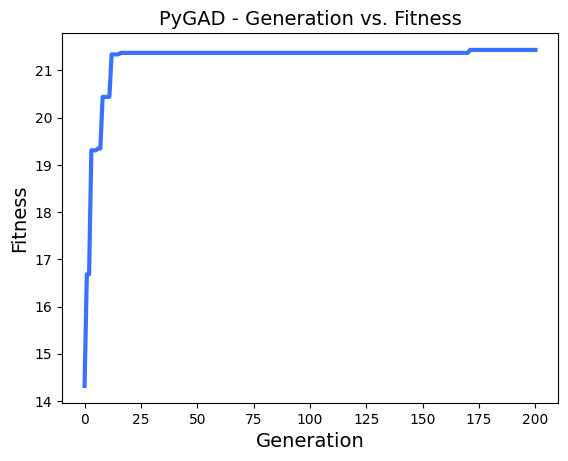

In [6]:
##### Train params with GA, do joint optimization of both the ticks traj and the velocity traj
##### in order to better constrain the problem and not let the parameters explode. Put regularization
##### on them, which penalizes the distance from the predefined values
#####################################################################################################

ground_truth_traj = poses[['pose.position.x', 'pose.position.y']].to_numpy()

'''The fitness function takes three components: error of the trajectory, 
params to optimize: [r, l, w, N]
'''
def fitness_func(solution, solution_idx):
    reg = 0.04
    alpha = 0.49 #(1-reg)//2
    beta = 1-(alpha+reg) #alpha
    
    r, l, w, N = solution
    
    traj_ticks = compute_trajectory(wheel_states, poses, r=r, l=l, w=w, N=N, use_ticks=True)
    error_ticks = compute_avg_dist(ground_truth_traj, traj_ticks)
    
    traj_vel = compute_trajectory(wheel_states, poses, r=r, l=l, w=w, N=N, use_ticks=False)
    error_vel = compute_avg_dist(ground_truth_traj, traj_vel)
    
    params_reg = compute_params_loss(r, l, w, N)
    
    loss = (alpha*error_ticks + beta*error_vel + reg*params_reg)
    fitness = 1.0 / (loss + 0.00000001)
    return fitness



num_generations = 200
with tqdm.tqdm(total=num_generations) as pbar:
    ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=2,
                           fitness_func=fitness_func,
                           sol_per_pop=8,
                           num_genes=4,
                           gene_type= [float, float, float, int],
                           gene_space=[{'low':0.06, 'high':0.08},{'low':0.18, 'high':0.22},
                                       {'low':0.149, 'high':0.189},{'low':37, 'high':47}],
                           init_range_low=0.05,
                           init_range_high=40,
                           parent_selection_type="sss",
                           keep_parents=1,
                           crossover_type="single_point",
                           mutation_type="random",
                           mutation_percent_genes=25,
                           on_generation=lambda _: pbar.update(1))
    ga_instance.run()


solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

ga_instance.plot_fitness()

*OLD*

Before ground truth in (0,0)
Best solution optimizing for ticks and vel Euler:

With regularization, n_points=100: [0.06869306658047952 0.19677916621852182 0.1634837238369686 30]

With n_points=500 [0.07053307184311323 0.20026496982195613 0.16812840338455232 30]

With reg=0.02 [0.06940571058247846 0.16236160889939028 0.2005053831642114 30]

Without regularization [0.06700294900628204 0.2038783699236767 0.15102976644062502 30]

For ticks only:
With no regularization [0.1261988494689742 0.19027336114035903 0.16564888397366867 56]

*OLD*

After ground truth in (0,0)

With reg=0.04 [0.06935527221926528 0.17891531101278274 0.18296470233237128 31]

Without vel [0.0696577177698737 0.2012292431510977 0.1664132612572134 30]

Without vel, decreased weight of regular [0.08194211262490685 0.1935664260878021 0.16757717346098577 36]


-> With vel, reg=0.04, alpha=0.5 [0.06960906483385901 0.1990282346009425 0.16770867149490737 30]

*OLD*

After trajectory started from initial pose in GT

With vel, reg=0.04, alpha=0.5 [0.07141434831182306 0.20198446428120226 0.16443327942684077 31]

With vel, reg=0.04, alpha=0.49 [0.06828222915434144 0.21141238518529165 0.1489485992118777 30]

*OLD*

With new limit of 2 cm fine-tuning on most params

With vel, reg=0.04, alpha=0.49 [0.06919071555393322 0.19651750481633457 0.16809771609416624 30]

*LAST*

On bag3:
[0.07007972256976944 0.19943134513875557 0.1680582071314848 38]

On bag2:
[0.06536492560924695 0.18250185337017752 0.16515443675414418 37]

On bag1:
[0.06920374362066399 0.19992610213463496 0.16913026877649368 38]

On bag3 with no regularization:
[0.0700368088348283 0.1812399329620913 0.18574904307836762 38]